# Preprocess data

This notebook takes in the .mat data from https://cs.nyu.edu/~silberman/datasets/nyu_depth_v2.html and preprocesses it into a more easily usable format.

## Import libraries and set up paths

In [1]:
import os
import json
import h5py

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from scipy import ndimage
from utils.utils import *

In [2]:
proj_dir = os.getcwd()
data_dir = os.path.join(proj_dir, 'data')
util_dir = os.path.join(proj_dir, 'utils')
analysis_dir = os.path.join(proj_dir, 'analysis')

## Read in data

In [3]:
# read in Labeled data from https://cs.nyu.edu/~silberman/datasets/nyu_depth_v2.html
f = h5py.File(os.path.join(data_dir, 'nyu_depth_v2_labeled.mat'), mode='r')
features = {}
for k, v in f.items():
    features[k] = np.array(v)

# read in name mapping dict
with open(os.path.join(data_dir, 'namesToIds.json')) as json_file:
    namesToIds = json.load(json_file)
namesToIds['unlabeled'] = 0
idsToNames = {v: k for k, v in namesToIds.items()}

print('.mat file vars: \n')
for key, val in features.items():
    print(f'{key}: {val.shape}')

.mat file vars: 

#refs#: (8484,)
#subsystem#: (1,)
accelData: (4, 1449)
depths: (1449, 640, 480)
images: (1449, 3, 640, 480)
instances: (1449, 640, 480)
labels: (1449, 640, 480)
names: (1, 894)
namesToIds: (1, 6)
rawDepthFilenames: (1, 1449)
rawDepths: (1449, 640, 480)
rawRgbFilenames: (1, 1449)
sceneTypes: (1, 1449)
scenes: (1, 1449)


In [4]:
# convert .mat references to local arrays
label_names = sorted([''.join(chr(c) for c in f[ref]) for ref in features['names'][0]])

## construct data files

### Convert and save image-related data to $(num\_obs, height, width, num\_features)$ .npy format

In [5]:
inds = np.arange(features['images'].shape[0])
if not os.path.exists(os.path.join(data_dir, 'image_arr.npy')):
    # reshape data into correct format and rotation
    features['images'] = np.moveaxis(features['images'], 1, -1)
    features['depths'] = np.moveaxis(features['depths'], 1, -1)
    features['labels'] = np.moveaxis(features['labels'], 1, -1)
    features['instances'] = np.moveaxis(features['instances'], 1, -1)

    imgs_aligned, depths_aligned, labels_aligned, instances_aligned = [], [], [], []
    for i in inds:
        imgs_aligned.append(ndimage.rotate(features['images'][i], -90))
        depths_aligned.append(np.fliplr(features['depths'][i]))
        labels_aligned.append(np.fliplr(features['labels'][i]))
        instances_aligned.append(np.fliplr(features['instances'][i]))

    imgs_aligned = np.asarray(imgs_aligned)
    depths_aligned = np.asarray(depths_aligned)
    labels_aligned = np.asarray(labels_aligned)
    instances_aligned = np.asarray(instances_aligned)

    print(f'Image reshaped: {imgs_aligned.shape}')
    print(f'Depth reshaped: {depths_aligned.shape}')
    print(f'Label reshaped: {labels_aligned.shape}')
    print(f'Instance reshaped: {instances_aligned.shape}')
    
    np.save(os.path.join(data_dir, 'image_arr.npy'), imgs_aligned)
    np.save(os.path.join(data_dir, 'depth_arr.npy'), depths_aligned)
    np.save(os.path.join(data_dir, 'label_arr.npy'), labels_aligned)
    np.save(os.path.join(data_dir, 'instance_arr.npy'), instances_aligned)
else:
    imgmat = np.memmap(os.path.join(data_dir, 'image_arr.npy'), dtype='uint8', mode='r', 
                       offset=128, shape=(1449,480,640,3))
    depmat = np.memmap(os.path.join(data_dir, 'depth_arr.npy'), dtype='<f4', mode='r', 
                       offset=128, shape=(1449,480,640))
    labmat = np.memmap(os.path.join(data_dir, 'label_arr.npy'), dtype='uint16', mode='r', 
                      offset=128, shape=(1449,480,640))
    instmat = np.memmap(os.path.join(data_dir, 'instance_arr.npy'), dtype='uint8', mode='r', 
                      offset=128, shape=(1449,480,640))

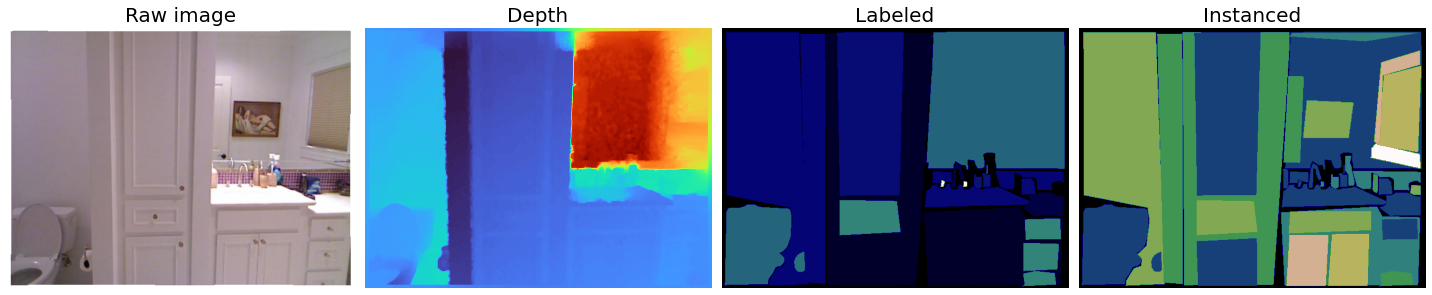

In [6]:
# show resulting data
samp = np.random.choice(inds)

fig, axs = plt.subplots(1,4, figsize=(20,6))

axs[0].imshow(imgmat[samp])
axs[1].imshow(depmat[samp], cmap='turbo')
axs[2].imshow(labmat[samp], cmap='gist_earth')
axs[3].imshow(instmat[samp], cmap='gist_earth')

[ax.axis('off') for ax in axs]
axs[0].set_title('Raw image', fontsize=20)
axs[1].set_title('Depth', fontsize=20)
axs[2].set_title('Labeled', fontsize=20)
axs[3].set_title('Instanced', fontsize=20)

fig.tight_layout()

### Convert and save other relevant data to pandas dataframe

In [7]:
# we want the unique instances and labels that exist in each image.
df = pd.DataFrame(index=inds, columns=['index', 'scene', 'scene_type', 'labels', 'instances'])
df['index'] = inds
df['scene'] = [''.join(chr(c) for c in f[ref]) for ref in features['scenes'][0]]
df['scene_type'] = [''.join(chr(c) for c in f[ref]) for ref in features['sceneTypes'][0]]

In [8]:
# compute unique instances and labels for each image
if not os.path.exists(os.path.join(data_dir, 'metadata.csv')):
    i = 0
    undersc = np.full(labmat[0].shape, '_', dtype='str')
    for batch in tqdm(split_given_size(inds, 64)):

        labs = vec_translate(labmat[batch], idsToNames)
        insts = instmat[batch].astype(str)
        insts_full = [np.char.add(np.char.add(lab, undersc), inst) for lab, inst in zip(labs, insts)]

        labs_unique = [list(np.unique(lab)) for lab in labs]
        insts_unique = [list(np.unique(inst)) for inst in insts_full]

        df.loc[batch, 'labels'] = np.array(labs_unique, dtype='object')
        df.loc[batch, 'instances'] = np.array(insts_unique, dtype='object')

    df.to_csv(os.path.join(data_dir, 'metadata.csv'), index=False)
else:
    df = pd.read_csv(os.path.join(data_dir, 'metadata.csv'))

In [9]:
df.head()

,index,scene,scene_type,labels,instances
0,0,kitchen_0004,kitchen,"['book', 'bottle', 'cabinet', 'ceiling', 'chai...","['book_1', 'bottle_1', 'cabinet_1', 'cabinet_2..."
1,1,kitchen_0004,kitchen,"['bottle', 'bowl', 'cabinet', 'ceiling', 'coun...","['bottle_1', 'bottle_2', 'bottle_3', 'bottle_4..."
2,2,office_0003,office,"['air vent', 'book', 'box', 'chair', 'door', '...","['air vent_1', 'air vent_2', 'book_1', 'box_1'..."
3,3,office_0003,office,"['bottle', 'cabinet', 'chair', 'cork board', '...","['bottle_1', 'bottle_10', 'bottle_11', 'bottle..."
4,4,office_0004,office,"['air duct', 'basket', 'bottle', 'cabinet', 'c...","['air duct_1', 'basket_1', 'basket_2', 'bottle..."
